# Startups operations/close predictions

**Задача**

На входе имеются данные о стартапах, функционировавших в период с 1970 по 2018 годы. Необходимо разработать модель для предсказания успешности стартапа (закроется или нет).

Файлы:
1) kaggle_startups_train_28062024.csv - тренировочная выборка

2) kaggle_startups_test_28062024.csv - входные признаки тестовой выборки

Описание полей данных

name - Название стартапа

category_list - Список категорий, к которым относится стартап

funding_total_usd - Общая сумма финансирования в USD

status - Статус стартапа (закрыт или действующий)

country_code - Код страны

state_code - Код штата

region - Регион

city - Город

funding_rounds - Количество раундов финансирования

founded_at - Дата основания

first_funding_at - Дата первого раунда финансирования

last_funding_at - Дата последнего раунда финансирования

closed_at - Дата закрытия стартапа (если применимо)

lifetime - Время существования стартапа в днях

In [38]:
# !pip install scikit-learn
# !pip install shap
# !pip install phik
# !pip install imbalanced-learn 
# !pip install category_encoders
#!pip install -q feature_engine
#!pip install catboost

In [ ]:
from datetime import date, datetime 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from catboost import CatBoostClassifier
import shap
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import ADASYN
from imblearn.base import FunctionSampler
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
from feature_engine.selection import DropCorrelatedFeatures, DropConstantFeatures

## Загрузка данных

In [40]:
train_dates_column_names = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
test_dates_column_names = ['first_funding_at', 'last_funding_at']

startups_train = pd.read_csv('./datasets/kaggle_startups_train_28062024.csv', parse_dates=train_dates_column_names)
startups_test = pd.read_csv('./datasets/kaggle_startups_test_28062024.csv', parse_dates=test_dates_column_names)

In [41]:
def tables_info():
    display(startups_train.head())
    display(startups_train.info())
    display(startups_test.head())
    display(startups_test.info())

In [42]:
tables_info()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

None

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


None

При загрузке проблем не обнаружено. В некоторых столбцах есть пропуски, возможно, требующие обработки.

## Предобработка данных

In [43]:
startups_train[startups_train.duplicated()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


In [44]:
startups_test[startups_test.duplicated()]

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime


In [45]:
startups_train[startups_train.duplicated(subset=['name'])]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


In [46]:
startups_test[startups_test.duplicated(subset=['name'])]


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime


In [47]:
list(startups_train['category_list'].unique())

['Online Reservations|Restaurants',
 'Manufacturing|Medical|Medical Devices',
 'Biotechnology',
 'Health Care',
 'Manufacturing',
 'Mobile',
 'Analytics|Business Analytics|Social CRM|Social Media Monitoring|Software',
 'Software',
 'Semiconductors',
 'Clean Technology',
 nan,
 'Nanotechnology|Technology|Wine And Spirits',
 'Customer Service|Delivery|Retail',
 'Analytics|Cloud Data Services|Computers|Networking|Software',
 'Banking|Finance|Loyalty Programs',
 'Messaging',
 'Consumers',
 'Generation Y-Z|Photo Sharing|Social Media',
 'College Recruiting|Enterprise Software|Recruiting|SaaS|Social Recruiting|Software',
 'Technology',
 'Finance|Financial Services|Payments',
 'Cloud Computing|Enterprise Resource Planning|Manufacturing|Software',
 'DIY|Environmental Innovation',
 'Entertainment|Games',
 'Internet|Pets|Services',
 'Advertising|Sales and Marketing',
 'Fitness|Sports',
 'Consumer Goods|Food Processing|Organic Food',
 'Analytics|Big Data|Business Intelligence|Marketplaces',
 'Mone

In [48]:
startups_train.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

In [49]:
startups_test.isna().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

Явных дубликатов не обнаружено. Стоит отметить, что в категориальных признаках таких как `category_list`, `country_code`, `region`, `city` много уникальных значений, которые сложно проанализировать на предмет неявных дублей. Также видно, что в категориях стартапов `category_list` есть перересекающиеся категории, например: `Manufacturing|Medical|Medical Devices` и `Manufacturing`.

В данных присутствует множество пропусков - решено не удалять данные с пропусками и заполнить их в pipeline на этапе обучения модели.

## Исследовательский анализ данных

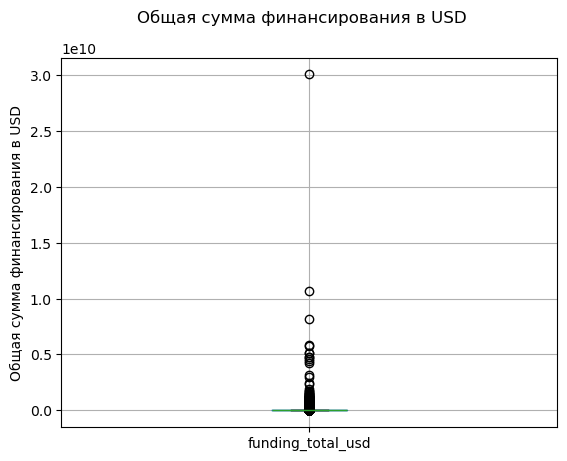

In [50]:
plt.suptitle('Общая сумма финансирования в USD')
funding_total_boxplot = startups_train.boxplot(column='funding_total_usd');
funding_total_boxplot.set_ylabel('Общая сумма финансирования в USD');

In [51]:
startups_train['funding_total_usd'].describe()

count    4.244700e+04
mean     1.824748e+07
std      1.871173e+08
min      1.000000e+00
25%      3.360275e+05
50%      2.000000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64

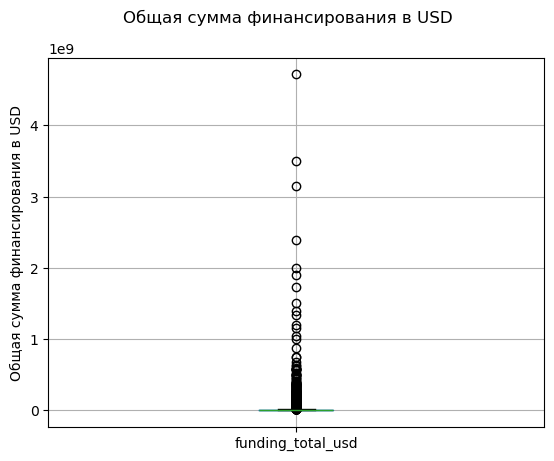

In [52]:
plt.suptitle('Общая сумма финансирования в USD')
funding_total_test_boxplot = startups_test.boxplot(column='funding_total_usd');
funding_total_test_boxplot.set_ylabel('Общая сумма финансирования в USD');

In [53]:
startups_test['funding_total_usd'].describe()

count    1.054700e+04
mean     1.654910e+07
std      9.217283e+07
min      1.000000e+00
25%      3.200000e+05
50%      2.000000e+06
75%      1.000000e+07
max      4.715000e+09
Name: funding_total_usd, dtype: float64

Финансирование стартапов имеет большой разброс по суммам инвестиций. Среднее значение в обучающей выборке ~ 18 млн, в тестовой - 16 млн. Интересно, что даже есть инвестиции размером в 1 доллар.

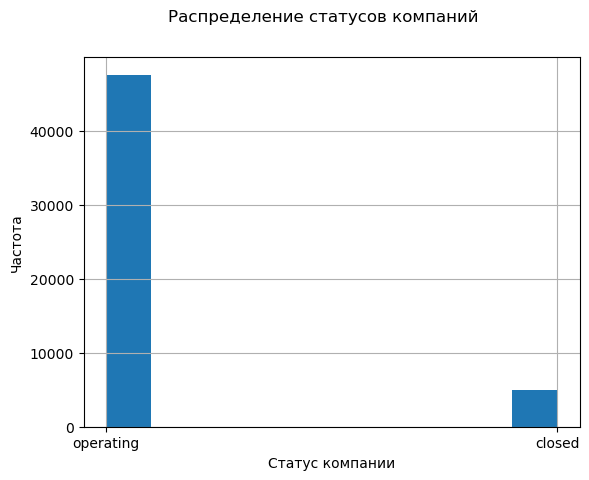

In [54]:
plt.suptitle('Распределение статусов компаний')
status_hist = startups_train['status'].hist();
status_hist.set_xlabel('Статус компании');
status_hist.set_ylabel('Частота');

По графику видно, что закрытых конпаний намного меньше (менее 10%). Следовательно нужно учесть, что при обучении возможна проблема дисбаланса классов.

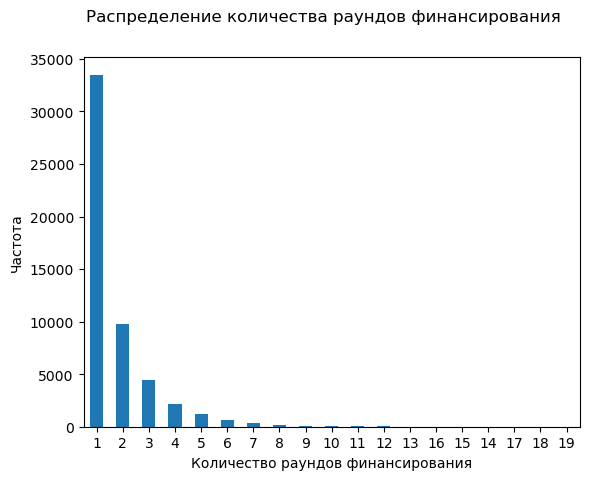

In [55]:
plt.suptitle('Распределение количества раундов финансирования')
funding_rounds_hist = startups_train['funding_rounds'].value_counts().plot(kind='bar', rot=0);
funding_rounds_hist.set_xlabel('Количество раундов финансирования');
funding_rounds_hist.set_ylabel('Частота');

In [56]:
startups_train['funding_rounds'].describe()

count    52516.000000
mean         1.740670
std          1.374522
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         19.000000
Name: funding_rounds, dtype: float64

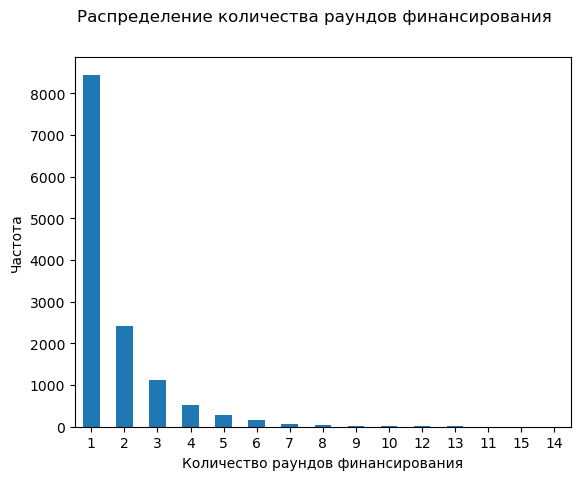

In [57]:
plt.suptitle('Распределение количества раундов финансирования')
funding_rounds_hist_test = startups_test['funding_rounds'].value_counts().plot(kind='bar', rot=0);
funding_rounds_hist_test.set_xlabel('Количество раундов финансирования');
funding_rounds_hist_test.set_ylabel('Частота');

In [58]:
startups_test['funding_rounds'].describe()

count    13125.000000
mean         1.714438
std          1.318800
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         15.000000
Name: funding_rounds, dtype: float64

В большистве случаев у компаний только один или два раунда финансирования. В среднем ~ 1.7 раундов. 

## Корреляционный анализ

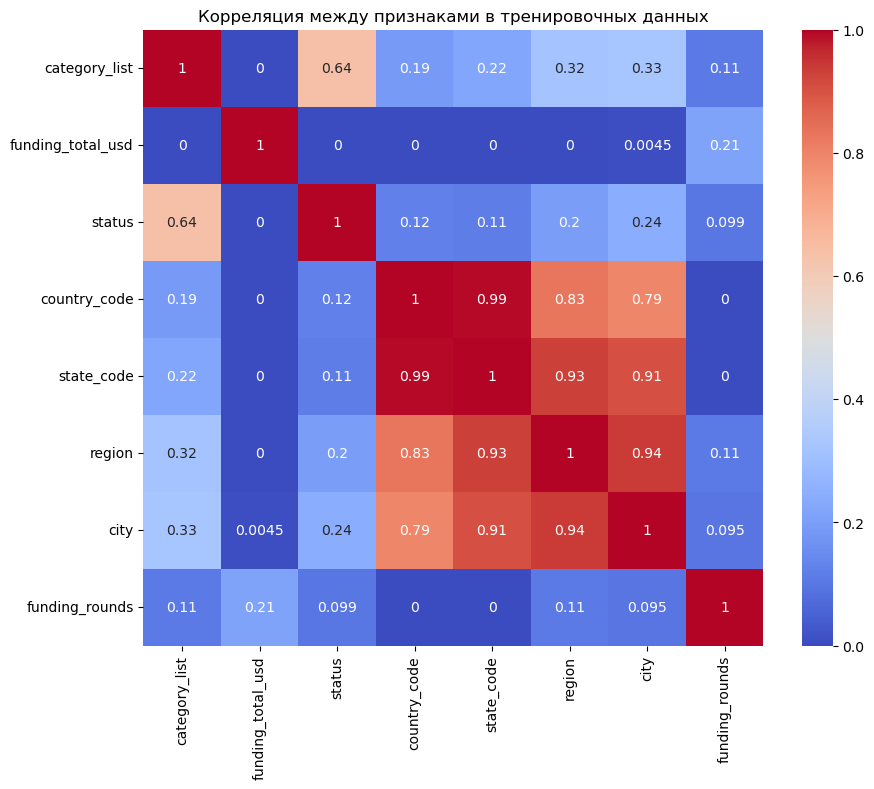

In [ ]:
#Перед корреляционным анализом закодируем категориальные признаки, ищеющие много уникальных значений.
#Это необхоимо сделать, чтобы расчет корреляции был меннее затратным
statuses = LabelEncoder().fit_transform(startups_train['status'])
enc_cat = TargetEncoder().fit_transform(startups_train[['category_list', 'region', 'city']], statuses)

startups_train_cor = startups_train.copy()
startups_train_cor['category_list'] = enc_cat['category_list']
startups_train_cor['region'] = enc_cat['region']
startups_train_cor['city'] = enc_cat['city']

interval_cols = ['funding_total_usd', 'funding_rounds', 'category_list', 'region', 'city']

# #Вычисление матрицы корреляции с использованием phik
corr_matrix = (
    startups_train_cor.drop(['name', 'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'], axis=1)
        .phik_matrix(interval_cols=interval_cols)
)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляция между признаками в тренировочных данных')
plt.show()

Из корреляционного анализа видно, что в геоданных (столбцы `city`, `country_code`, `state_code`, `region`) есть сильная корреляция. Возможно стоит отобрать только один из признаков для геоданных.

## Подготовка данных

In [60]:
#Подсчитывает и вставляет в столбец количество дней между первым и последним раундами финансирования компании
#Если дата первого или последнего раунда пустые, устанавливает значение 0
def set_funding_period(row):
    if row['first_funding_at'] == np.nan or row['last_funding_at'] == np.nan:
        row['funding_period'] = 0
    else:
        row['funding_period'] = (row['last_funding_at'] - row['first_funding_at']).days
    return row

startups_train = startups_train.apply(set_funding_period, axis=1)
startups_test = startups_test.apply(set_funding_period, axis=1);

In [61]:
#Подсчитывает и вставляет в столбец количество дней существования компании
def set_lifetime(row): 
    if pd.isna(row['founded_at']):
        row['lifetime'] = np.nan
        return row
    if pd.isna(row['closed_at']):
        row['lifetime'] = (datetime(2018, 1, 1) - row['founded_at']).days
    else:
        row['lifetime'] = (row['closed_at'] - row['founded_at']).days
    return row

startups_train = startups_train.apply(set_lifetime, axis=1)

In [62]:
# функция оставляет только первую категорию стартапа из списка всех категорий, разделенных символом "|"
# def clean_category(row):
#     if not pd.isna(row['category_list']):
#         parts = row['category_list'].split('|')
#         row['category_list'] = parts[0].strip()
#     return row

# startups_train = startups_train.apply(clean_category, axis=1)
# startups_test = startups_test.apply(clean_category, axis=1);

In [63]:
new_train = startups_train.drop(['name', 'first_funding_at', 'last_funding_at', 'founded_at', 'closed_at', 'region', 'country_code', 'state_code'], axis=1)
new_train

,category_list,funding_total_usd,status,city,funding_rounds,funding_period,lifetime
0,Online Reservations|Restaurants,828626.0,operating,Zürich,2,1310,2998
1,Manufacturing|Medical|Medical Devices,42935019.0,operating,Redwood City,4,1393,4748
2,Biotechnology,35456381.0,operating,San Jose,3,681,4383
3,Health Care,22250000.0,operating,NaN,3,1051,5114
4,Manufacturing,NaN,operating,Bristol,1,0,2791
...,...,...,...,...,...,...,...
52511,Entertainment,NaN,operating,Kitchener,1,0,2192
52512,Hospitality,500000.0,operating,Hyderabad,1,0,1590
52513,Email|Messaging|Productivity Software,50000.0,operating,San Francisco,3,566,2741
52514,Security,13000000.0,operating,San Jose,6,1918,7336


In [64]:
new_test = startups_test.drop(['name', 'first_funding_at', 'last_funding_at', 'region', 'country_code', 'state_code'], axis=1)
new_test

,category_list,funding_total_usd,city,funding_rounds,lifetime,funding_period
0,Clean Technology,2819200.0,NaN,1,3501,0
1,Hospitality,NaN,Humboldt,1,2717,0
2,Finance,428257.0,Esch-sur-alzette,2,1295,126
3,Software|Video|Video Streaming,34700000.0,San Diego,4,4748,1935
4,Software,4530000.0,Ottawa,1,6209,0
...,...,...,...,...,...,...
13120,Recruiting,28000.0,Sunnyvale,1,2267,0
13121,Software,NaN,Mountain View,1,2192,0
13122,Design|E-Commerce|Marketplaces|Printing,5600000.0,Seattle,3,2922,1030
13123,Advertising Exchanges|Mobile|Mobile Advertising,150000.0,New York,2,1386,38


In [65]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train = new_train.drop(['status'], axis=1)
X_test = new_test.copy()
y_train = new_train['status']

le_status = LabelEncoder()
le_status.fit(new_train['status'])
y_train = le_status.transform(y_train)

print(f'Размер тренировочный выборки {X_train.shape}\nРазмер тестовой выборки {X_test.shape}')

Размер тренировочный выборки (52516, 6)
Размер тестовой выборки (13125, 6)


In [66]:
# создаём списки с названиями признаков
cat_columns = ['category_list', 'city']
num_columns = ['funding_total_usd', 'funding_period', 'lifetime']

# создаём пайплайн для подготовки признаков из списка категориальных признаков: заполнение пропусков и кодирование
cat_pipe = Pipeline(
    [('simpleImputer_cat', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('target_encoder', TargetEncoder())
    ]
)

# создаём пайплайн для подготовки признаков из списка числовых признаков: заполнение пропусков и масштабирование ит.д
num_pipe = Pipeline(
    [('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
     ('scaler', StandardScaler()),
     ('poly', PolynomialFeatures()),
     ('drop_correlated', DropCorrelatedFeatures(threshold=0.9)),
     ('drop_constant', DropConstantFeatures())
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
     ('cat', cat_pipe, cat_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

На этом этапе добавили новые признаки `lifetime` и `funding_period`, время существования компании и период между первым и последним раундами финансирования соответственно. Также здесь удалили признаки, которые не будут участвовать в обучении.

## Обучение моделей

In [74]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = make_imblearn_pipeline(data_preprocessor,                     
                         SMOTETomek(random_state=RANDOM_STATE, n_jobs=-1),
                         DecisionTreeClassifier(random_state=RANDOM_STATE)).set_output(transform="pandas") 

pipe_final.steps[-1] = ('models', pipe_final.steps[-1][1])

In [ ]:
# создаём итоговый пайплайн
param_grid = [
    #словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [2, 4, 8, 16, 32],
        'models__max_features': [2, 4, 8, 16, 32],
        'models__min_samples_split': [2, 4, 8, 16, 32],
        'models__min_samples_leaf': [2, 4, 8, 16, 32],
        'smotetomek': [SMOTETomek(random_state=RANDOM_STATE), ADASYN(random_state=RANDOM_STATE), 'passthrough'],
    },

    #словарь для модели DecisionTreeClassifier() без оверсемплинга
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': [2, 4, 8, 16, 32],
        'models__max_features': [2, 4, 8, 16, 32],
        'models__min_samples_split': [2, 4, 8, 16, 32],
        'models__min_samples_leaf': [2, 4, 8, 16, 32],
        'smotetomek': ['passthrough'],
    },

    #словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 20),
        'smotetomek': [SMOTETomek(random_state=RANDOM_STATE), ADASYN(random_state=RANDOM_STATE), 'passthrough'] 
    },

    #словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(cat_features=[0,1], verbose=False, random_state=RANDOM_STATE)],
        'models__iterations': [500, 1000],
        'models__depth': [2, 4, 6, 8],
        'models__learning_rate': [0.05, 0.1, 1],
        'smotetomek': ['passthrough'],
        'columntransformer__cat__target_encoder': ['passthrough'],
        'columntransformer__num__poly': ['passthrough', PolynomialFeatures()],
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_iter=300,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

c:\pylib\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\pylib\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\pylib\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\pylib\Lib\site-packages\imblearn\pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('simpleImputer_cat',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('target_encoder',
                                                                                                TargetEncoder())]),
                                                                               ['category_list',
                                                                                'city']),
                                                                              ('num',
                                                                               Pipeline(steps=[('simpleImputer_num',
                                                                                                SimpleImputer(strategy='median'...
                                        {'columntransformer__cat__target_encoder': ['passthrough'],
                                         'columntransformer__num__poly': ['passthrough',
                                                                          PolynomialFeatures()],
                                         'models': [<catboost.core.CatBoostClassifier object at 0x0000022C9A41F9E0>],
                                         'models__depth': [2, 4, 6, 8],
                                         'models__iterations': [500, 1000],
                                         'models__learning_rate': [0.05, 0.1,
                                                                   1],
                                         'smotetomek': ['passthrough']}],
                   random_state=42, scoring='f1')

In [76]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpleImputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   'passthrough')]),
                                                  ['category_list', 'city']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleImputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                            

In [77]:
print ('Результат на кросс-валидации:', randomized_search.best_score_)

Результат на кросс-валидации: 0.9761624954853426


In [78]:
y_test_pred = randomized_search.predict(X_test)

list_of_series = [startups_test['name'], pd.Series(le_status.inverse_transform(y_test_pred))]
df = pd.concat(list_of_series, axis=1)
df.columns = ['name', 'status']
df

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating
...,...,...
13120,Jymob,operating
13121,GlobaTrek,operating
13122,Inkd.com,operating
13123,AdWill,operating


In [79]:
#Сохранение результатов предсказаний на тестовой выборке для проверки на Kaggle 
df.to_csv('submition.csv', index=False)

В качестве лучшей модели выбрана `CatBoostClassifier`, в качестве метрики использовалась метрика `f1`. Результат на кросс-валидации оказался довольно высоким, возможно модель переобучилась. На тестовой выборке данная модель показала неочень высокие результаты ~0,75.

## Анализ важности признаков

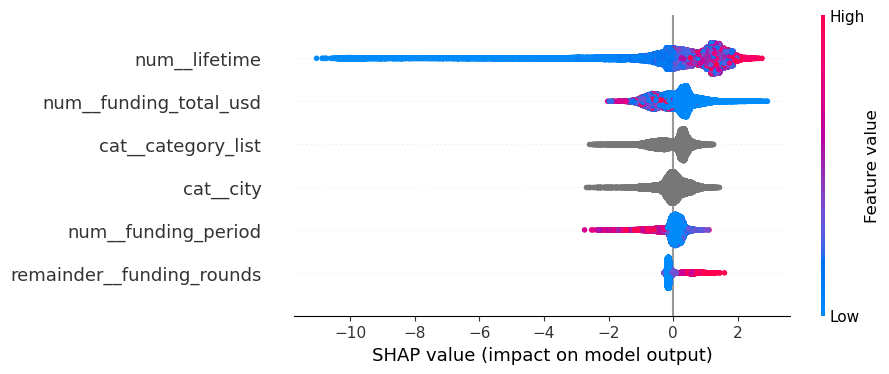

In [80]:
explainer = shap.TreeExplainer(randomized_search.best_estimator_['models'])

X_train_prep = randomized_search.best_estimator_.named_steps['columntransformer'].transform(X_train)
feature_names = randomized_search.best_estimator_.named_steps['columntransformer'].get_feature_names_out()
X_train_prep = pd.DataFrame(X_train_prep, columns=feature_names)

shap_values = explainer(X_train_prep, y_train)
shap.plots.beeswarm(shap_values)

In [81]:
# Анализ важности признаков на случай когда все признаки числовые

# X_test_prep = randomized_search.best_estimator_.named_steps['columntransformer'].transform(X_test)
# feature_names = randomized_search.best_estimator_.named_steps['columntransformer'].get_feature_names_out()

# X_test_prep = pd.DataFrame(X_test_prep, columns=feature_names)
# X_test_prep

# kmeans_summary = shap.kmeans(X_test_prep, 5)

# explainer = shap.KernelExplainer(
#     lambda X: randomized_search.best_estimator_['models'].predict_proba(X)[:, 1], 
#     kmeans_summary, 
#     feature_names=X_test_prep.columns
# )

# shap_values = explainer(X_test_prep)

# shap.plots.beeswarm(shap_values)

Из графика видно, что наибольший вклад вносят признаки:
- время существования компании (`lifetime`), низкие значения признака склоняют модель к классу closed
- общая сумма инвестиций в компанию (`funding_total_usd`), низкие значения повышают вероятность класса operating
- признаки категории и города стартапа тоже вносят вклад в классификацию, но проанализировать вклад определенных значений этих признаков не представляется возможным
- чем дольше период между первым раундом финансирования стартапа и последним тем больше вероятность, что стартап закроется 

## Общий вывод

В данной работе необходимо было разработать решение, которое позволит предсказать успешность стартапа (закроется или нет). Для обучения моделей были представлены данные о стартапах, функционировавших в период с 1970 по 2018 годы. 

Для повышения качества данных проведена предобработка данных: проверка на явные дубли в данных (не обнаружено), даты приведены к типу datetime.

Также проведен исследовательский и корреляционный анализ данных для выявления аномалий, выбросов и мультиколлинеарности. На данных этапах было обнаружено, что в тренировочных данных наблюдается дисбаланс классов (компаний со статусом closed намного больше) и мультиколлинеарность признаков отвечающих за географические данные компаний (страна, город, регион итд.). Также стоит отметить сложности, в частности, признак категории стартапа `category_list` имеет очень много возможных значений, которые сложно проанализировать на неявные дубли и закодировать для обучения моделей, неимеющих встроенных возможностей работы с сырыми категориальными признаками.

Для поиска лучшей модели был подготовлен пайплайн включающий в себя этапы подготовки данных для обучения модели (кодирование категориальных принзнаков, масштабирование принзнаков итд) и этап поиска оптимальной модели путем рандомизированного перебора гиперпараметров 3 моделей (логистическая регрессия, древо решений, CatBoostClassifier). При подборе гипперпараметров предусмотренны варинты пайплайна, когда перед обучением модели выполняется оверсемплинг для устранения дисбаланса классов. В качестве метрики качества использовалась метрика f1.
В качестве лучше модели выбрана CatBoostClassifier. На кросс-валидации модель показала завышенные результаты, что говорит о возможном переобучении. На тестовых данных модель показала результат ~0,75.

Анализ важности признаков показал, что чем меньше существует стартап тем больше вероятность его закрытия. Также невысокие суммы финансирования повышают вероятность выживания стартапа.

